In [51]:
# CF Techniques = Memory Based & Model Based
# CF can be divided into USER BASED(USER-USER) & ITEM BASED(ITEM-ITEM)
#       There are two classes of Collaborative Filtering:
#       User-based, which measures the similarity between target users and other users.
#       Item-based, which measures the similarity between the items that target users rate or interact with and other items.

# 
# Memory Based Techniques--> 
#       1.EUCLIDEAN DISTANCE
#       2.COSINE SIMILARITY (USED)
#       3.PEARSONS CORRELATION

# Model Based Techniques-->
#       1.K-NEAREST NEIGHBORS (USED)
#       2.CLUSTERING
#       3.MATRIX FACTORIZATION (USED)
#       4.Deep Learning models like autoencoders and using techniques like embeddings 
#         as low-dimensionality hidden factors for items and user

# CLUSTERING BASED ALGORITHMS--> K-NEAREST NEIGHBORS(KNN) --> SURPRISE(LIBRARY)
#
# MATRIX FACTORIZATION BASED-->
#       1.SVD(SINGULAR VALUE DECOMPOSITION)
#       2.NON-ve MF
#       3.Probabilistic MF
#
# DEEP LEARNING BASED --> Multi-layered neural nets(including embedding layers)

# Dimensionality Reduction

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle

movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
ratings = pd.read_csv('ratings.csv')
links = pd.read_csv('links.csv')


# Removing the year from the title
movies['title'] = movies['title'].apply(lambda x: x[:-7])

movies.head()

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


In [53]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [54]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [55]:
links.head()


,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


# To Avoid Cold-Start Problem We Use Content Based Filtering


# DATA PREPROCESSING

# Content based filtering


In [56]:
movies['genres'] = movies['genres'].apply(lambda x:x.replace('|', ' '))
movies.head(2)

,movieId,title,genres
0,1,Toy Story,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,Adventure Children Fantasy


In [57]:
len(movies.movieId.unique()) #total no of movies in dataset that are unique


9742

In [58]:
len(ratings.movieId.unique()) #total no of unique ratings
print(len(ratings.userId.unique()))

610


In [59]:
# limit ratings to user ratings that have rated more than 55 times
# otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering

ratings_f = ratings.groupby('userId').filter(lambda x:len(x) >= 55)
print(len(ratings_f.userId), len(ratings_f.userId.unique()))
# list of the movie titles that survived the filtering 
movie_list_rating = ratings_f.movieId.unique().tolist() # 9625 movies in the list after filteration
len(movie_list_rating)

92729 364


9625

In [60]:
# We have kept 99% of the original movie titles in ratings data frame
print(len(ratings.movieId.unique())/len(movies.movieId.unique()) * 100, "%")

99.8152330117019 %


In [61]:
# users count in both new and old dataframe
# so the user percentage has been reduced to 59%
print(len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100, "%")

59.67213114754099 %


In [62]:
# filter the movie dataframe
# basically storing the list that we got from filtering above
movies = movies[movies.movieId.isin(movie_list_rating)]

movies.head()

,movieId,title,genres
0,1,Toy Story,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,Adventure Children Fantasy
2,3,Grumpier Old Men,Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy


In [63]:
# Mapping movies to id
Map_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))


In [64]:
# As we don't need timestamp column in our dataset so we will remove it from our datasets

ratings_f.drop(columns='timestamp', inplace=True)
tags.drop(columns='timestamp', inplace=True)


Merge the movies and the tags dataframe and create a metadata tag for each movie:


In [65]:
# basically were gonna create an overview of all the movies for content comparison
mixed = pd.merge(movies, tags, on='movieId',how='left')
mixed.head(2)


,movieId,title,genres,userId,tag
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story,Adventure Animation Children Comedy Fantasy,474.0,pixar


In [66]:
# creating metadata from tags and genres
mixed.fillna('',inplace=True)# avoiding any empty tags

# concatanating all the tags that the users have given according to the movieId
# for example movieId 1 is Toy Story so the tags for it are Owned imdb top 250 pixar etc
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x:"%s" % ' '.join(x)))

# finally merging the tag column from mixed dataframe to the movies dataframe
Final = pd.merge(movies, mixed, on='movieId',how='left')
# Creating a column called metadata in which we will store the metadata = genres + tags
Final['metadata'] = Final[['tag','genres']].apply(lambda x:' '.join(x), axis=1) 

#so our final dataframe looks something like this
Final = Final.drop(columns = ['tag', 'genres'])
Final.head()




,movieId,title,metadata
0,1,Toy Story,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men,moldy old Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,pregnancy remake Comedy


In [67]:
Final.shape # Shape of our dataframe i.e it has 9625 rows x 5 columns

(9625, 3)

Creating a content latent matrix (basically Matrix Factorization) from movie metadata:

tf-idf vectors and truncated SVD (Singular value decomposition):


In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english') # removing words like " for and to or "

# converting all the tags in the metadata into vectors (numerical representation of the metadata)
# we obtain a sparse matrix containing zeroes
tfidf_matrix = tfidf.fit_transform(Final['metadata']) #<58867x35541 sparse matrix of type '<class 'numpy.float64'>'

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
tfidf_df


,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The first 200 components explain over 80% of the variance

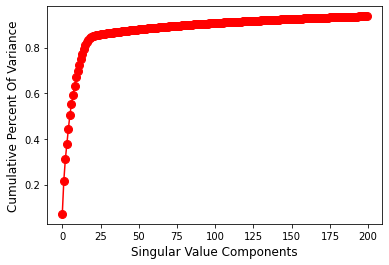

In [69]:
# Using Truncated SVD basically we are reducing the dimension of the matrix
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# Plotting a graph explaining from where the variance in similarity becomes constant
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-', ms = 16, color = 'red')
plt.xlabel('Singular Value Components', fontsize = 12)
plt.ylabel('Cumulative Percent Of Variance', fontsize = 12)
plt.show()


In [70]:
#number of latent dimensions to keep
n = 200
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())
latent_matrix_1_df


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story,0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,0.234567,-0.019392,-0.124586,-0.008614,...,-0.040791,-0.024777,-0.113820,-0.049008,-0.018268,-0.111976,0.180545,-0.184793,0.027297,0.041659
Jumanji,0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,0.189676,-0.012325,-0.078054,0.001669,...,-0.001640,0.002814,-0.010073,0.007965,-0.006755,0.004822,-0.008905,-0.011868,-0.001194,-0.001855
Grumpier Old Men,0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,-0.011973,0.000952,0.004727,-0.002093,...,-0.005030,0.001374,-0.001177,-0.001291,0.001401,-0.003262,0.001237,-0.007797,0.000202,0.004229
Waiting to Exhale,0.824508,0.064191,-0.292164,0.377882,0.274419,-0.082577,-0.046063,0.001273,0.028399,-0.000377,...,-0.000305,0.000160,0.000085,0.000303,-0.000400,-0.000237,0.000333,0.000065,-0.000093,0.000109
Father of the Bride Part II,0.113317,0.120747,-0.006328,-0.037081,-0.007424,0.010526,-0.009221,-0.001934,0.004463,-0.011439,...,0.009294,-0.003646,-0.014928,-0.000470,-0.002479,0.003999,0.022382,0.000806,0.000506,-0.012990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic,0.330390,0.220390,0.299348,0.156820,-0.328211,-0.097277,0.315186,-0.009244,0.040629,0.078732,...,-0.000364,0.000236,0.000226,0.000171,0.000286,0.000329,-0.000046,0.000087,0.000202,0.000498
No Game No Life: Zero,0.297372,0.274626,0.097661,0.111133,-0.226117,0.059137,0.398710,-0.037504,-0.243645,0.014165,...,-0.000388,0.000329,0.000077,-0.000013,0.000142,0.000532,-0.000174,0.000173,-0.000042,0.000520
Flint,0.631675,-0.667342,-0.301958,-0.123289,-0.166310,0.130080,-0.007132,-0.004549,0.024712,0.015193,...,-0.000056,-0.000055,-0.000053,-0.000028,-0.000144,-0.000091,0.000254,-0.000118,-0.000035,0.000064
Bungo Stray Dogs: Dead Apple,0.114018,-0.013212,0.337757,0.171087,-0.308274,-0.183802,0.176161,0.007630,0.139436,0.098689,...,-0.000343,0.000172,0.000477,0.000386,0.000339,0.000076,-0.000436,0.000236,0.000138,-0.000037


Creating Latent Matrix For Collaborative Filtering From User Ratings

In [71]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [72]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on='movieId', how='right')
ratings_f1.shape

(92729, 3)

In [73]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns = 'userId', values ='rating').fillna(0)



In [74]:
print(ratings_f2.shape)
ratings_f2.head(5)

(9625, 364)


userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [75]:
len(ratings_f.movieId.unique())

9625

In [76]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=Final.title.tolist())

In [77]:
latent_matrix_1_df.head(7)# it contains the numerical form of metadata

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story,0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,0.234567,-0.019392,-0.124586,-0.008614,...,-0.040791,-0.024777,-0.113820,-0.049008,-0.018268,-0.111976,0.180545,-0.184793,0.027297,0.041659
Jumanji,0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,0.189676,-0.012325,-0.078054,0.001669,...,-0.001640,0.002814,-0.010073,0.007965,-0.006755,0.004822,-0.008905,-0.011868,-0.001194,-0.001855
Grumpier Old Men,0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,-0.011973,0.000952,0.004727,-0.002093,...,-0.005030,0.001374,-0.001177,-0.001291,0.001401,-0.003262,0.001237,-0.007797,0.000202,0.004229
Waiting to Exhale,0.824508,0.064191,-0.292164,0.377882,0.274419,-0.082577,-0.046063,0.001273,0.028399,-0.000377,...,-0.000305,0.000160,0.000085,0.000303,-0.000400,-0.000237,0.000333,0.000065,-0.000093,0.000109
Father of the Bride Part II,0.113317,0.120747,-0.006328,-0.037081,-0.007424,0.010526,-0.009221,-0.001934,0.004463,-0.011439,...,0.009294,-0.003646,-0.014928,-0.000470,-0.002479,0.003999,0.022382,0.000806,0.000506,-0.012990
Heat,0.248284,-0.193538,0.723598,-0.199591,0.165240,-0.530794,-0.063083,-0.000683,-0.003843,0.063029,...,0.000161,-0.000110,0.000311,-0.000156,0.000049,-0.000325,-0.000103,-0.000061,0.000189,-0.000233
Sabrina,0.243798,0.172816,-0.068992,0.200344,0.162584,-0.065606,-0.018927,0.001524,0.007730,-0.004327,...,0.006568,0.010472,-0.021280,-0.002642,-0.022790,-0.004252,0.001720,-0.015621,0.005583,-0.015492


In [78]:
latent_matrix_2_df.head(7) #it contains the ratings from the different users

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story,36.391240,-4.958788,14.331820,1.844157,-3.077922,-1.351171,8.341427,-0.561088,-1.898201,1.657858,...,0.308790,-2.192011,0.962896,-0.143999,-1.449951,-0.353303,-0.961045,1.317185,-1.444388,-2.403061
Jumanji,20.447499,0.675231,11.354479,-7.325453,-3.505243,3.585611,4.393396,-5.564560,0.434471,0.351437,...,0.974166,0.619782,-1.013983,0.595879,1.098941,-0.317148,1.741729,0.787459,1.846033,0.746197
Grumpier Old Men,8.407816,-5.190801,4.378314,-6.189039,-0.333121,1.924149,-1.548363,0.795946,-3.196045,2.121790,...,0.898470,-0.276182,-0.255313,-0.509092,0.399285,-0.262368,-0.152588,-0.907095,-0.439095,0.472442
Waiting to Exhale,0.408037,-0.664700,0.739903,-0.202676,-0.498374,1.055409,0.184081,-0.508293,-0.429505,0.086538,...,-0.228245,0.112026,-0.226322,0.029540,-0.066050,0.210709,-0.053755,0.185463,0.183873,0.205658
Father of the Bride Part II,5.755079,-1.757369,3.961287,-3.673278,-3.688047,3.237859,1.140585,-0.690785,-2.171826,1.365962,...,0.048415,-0.514330,-0.757597,0.463755,-0.598090,0.261259,0.211794,-1.200778,-0.271661,0.086366
Heat,21.147710,-6.162329,7.098517,2.507193,6.830615,8.125510,-5.282011,-0.279929,5.225560,0.826434,...,-2.311441,-0.907647,1.964950,1.213062,0.681926,0.675519,0.622029,-1.869272,-1.585853,0.250669
Sabrina,6.168381,-4.654849,3.343397,-3.640084,-4.642767,5.257256,-0.176211,-0.764383,-0.495273,-1.106929,...,0.412169,0.075852,0.038398,0.604784,0.323318,-0.251221,-0.023051,-1.185796,0.442679,0.540537


In [79]:
print(latent_matrix_1_df.shape, latent_matrix_2_df.shape)

(9625, 200) (9625, 200)


Running a content / collaborative and hybrid cosine similarity

In [80]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content and collaborative matrices

a1 = np.array(latent_matrix_1_df.loc['Die Hard']).reshape(1, -1)
a2 = np.array(latent_matrix_2_df.loc['Die Hard']).reshape(1, -1)

# Calculating the similarity of this movie with the others in the list
score1 = cosine_similarity(latent_matrix_1_df, a1).reshape(-1)
score2 = cosine_similarity(latent_matrix_2_df, a2).reshape(-1)

# an average measure of both content and collaborative
hybrid = ((score1 + score2)/2.0)

#form a data frame of similar movies
dictDF = {'content': score1,'collaborative':score2,'hybrid':hybrid}
similar = pd.DataFrame(dictDF, index=Final.title)
#similar_df = pd.DataFrame(similar['movieId', 'title', 'content', 'collaborative', 'hybrid'])
#sorting it on the basis of either content, collaborative or hybrid
similar.sort_values('content', ascending=False, inplace=True)

similar.head(10)

,content,collaborative,hybrid
title,,,
Blitz,1.0,0.116649,0.558325
Safe,1.0,0.116649,0.558325
Ninja: Shadow of a Tear,1.0,0.118694,0.559347
"Crimson Rivers 2: Angels of the Apocalypse (Rivières pourpres II - Les anges de l'apocalypse, Les)",1.0,0.096715,0.548358
Someone to Watch Over Me,1.0,0.216035,0.608018
Hitman: Agent 47,1.0,0.119540,0.559770
"Equalizer, The",1.0,0.238055,0.619028
London Has Fallen,1.0,-0.011854,0.494073
Hard Rain,1.0,0.204169,0.602085


In [81]:
#pickle.dump(latent_matrix_1_df,open("latent_matrix_1_df,pkl","wb"))

In [82]:
#movies = movies[movies.movieId.isin(movie_list_rating)]
links = links[links.movieId.isin(ratings_f.movieId)]
Final = Final.merge(links['tmdbId'], on=Final.movieId) #---> Already Executed
Final.drop(columns= ['key_0', 'movieId'], inplace=True) #---> Already Executed
Final = Final.rename(columns={'tmdbId':'movieId'}, inplace=False)

Final.head(3)

,title,metadata,movieId
0,Toy Story,pixar pixar fun Adventure Animation Children C...,862
1,Jumanji,fantasy magic board game Robin Williams game A...,8844
2,Grumpier Old Men,moldy old Comedy Romance,15602


In [83]:
def recommend(movie):
    a1 = np.array(latent_matrix_1_df.loc[movie]).reshape(1, -1)
    a2 = np.array(latent_matrix_2_df.loc[movie]).reshape(1, -1)

    # Calculating the similarity of this movie with the others in the list
    score1 = cosine_similarity(latent_matrix_1_df, a1).reshape(-1)
    score2 = cosine_similarity(latent_matrix_2_df, a2).reshape(-1)

    type = 1

    if type == 1:
        content = sorted(enumerate(score1.tolist()), reverse=True, key=lambda x: x[1])
        for i in content[0:5]:
            print(Final.iloc[i[0]].title)

    elif type == 2:
        collaborative = sorted(enumerate(score2.tolist()), reverse=True, key=lambda x: x[1])
        for i in collaborative[0:5]:
            print(Final.iloc[i[0]].title)

    elif type == 3:
    # an average measure of both content and collaborative
        hybrid = sorted(enumerate(((score1 + score2)/2.0).tolist()), reverse=True, key=lambda x: x[1])
        for i in hybrid[0:5]:
            print(Final.iloc[i[0]].title)


In [84]:
recommend('Deadpool')


Fifth Element, The
Space Cowboys
Innerspace
Adventures of Pluto Nash, The
Last Starfighter, The


In [86]:
# Exporting all the necessary files for the frontend
pickle.dump(Final, open("Final.pkl", "wb"))
pickle.dump(content_latent_matrix,open("content_latent_matrix.pkl","wb"))
pickle.dump(collaborative_latent_matrix,open("collaborative_latent_matrix.pkl","wb"))
pickle.dump(movie_list,open("movie_list.pkl","wb"))